In [ ]:
# ==============================================================================
# LEGO QUALITÄTSKONTROLLE - FINALES PYTORCH-SKRIPT (v2)
# ==============================================================================
# Dieses Skript implementiert den gesamten Workflow für die Konzeption,
# das Training und die Evaluation eines Deep-Learning-Modells zur
# visuellen Qualitätskontrolle von LEGO-Modellen mittels Transfer Learning.
#
# Workflow:
# 1. Setup & Imports
# 2. Globale Konfiguration & Experiment-Setup
# 3. Helferfunktionen (z.B. für Visualisierungen)
# 4. Daten-Pipeline & visueller Sanity-Check
# 5. Modell-Definition
# 6. Training-Setup
# 7. Trainingsschleife
# 8. Finale Evaluation & Visualisierung
# 9. Fine-Tuning (Optionaler Schritt zur weiteren Verbesserung)
# ==============================================================================


# ------------------------------------------------------------------------------
# 1. SETUP & IMPORTS
# ------------------------------------------------------------------------------
import os
import random
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from timm.models import create_model
from torchinfo import summary
from torchmetrics import MeanMetric, Accuracy, F1Score, Precision, Recall, ConfusionMatrix

from codecarbon import EmissionsTracker
import pkbar

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# ------------------------------------------------------------------------------
# 2. GLOBALE KONFIGURATION & EXPERIMENT-SETUP
# ------------------------------------------------------------------------------

# -- Reproduzierbarkeit --
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -- Pfad-Management --
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
MODEL_DIR = os.path.join(ROOT_DIR, "models")
DATA_DIR = os.path.join(ROOT_DIR, "data")
os.makedirs(MODEL_DIR, exist_ok=True)

TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

# -- Hyperparameter --
BATCH_SIZE = 32
IMAGE_SIZE = 224
PRE_CROPPED_SIZE = 256
LEARN_RATE = 5e-5
NUM_EPOCHS = 20
MODEL_NAME = "efficientnet_b2"

# -- ImageNet-Statistiken für die Normalisierung --
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# -- Experiment-Ordner erstellen --
# Jeder Lauf wird in einem eigenen, zeitgestempelten Ordner gespeichert.
run_name = f"{datetime.now().strftime('%Y%m%d_%H%M')}_model-{MODEL_NAME}_lr-{LEARN_RATE}"
run_dir = os.path.join(MODEL_DIR, run_name)
os.makedirs(run_dir, exist_ok=True)
print(f"Neuer Lauf gestartet. Alle Artefakte werden in '{run_dir}' gespeichert.")

In [ ]:
# ------------------------------------------------------------------------------
# 3. HELFERFUNKTIONEN FÜR VISUALISIERUNG
# ------------------------------------------------------------------------------
def denormalization(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Wandelt einen normalisierten Tensor für die Anzeige zurück."""
    img_tensor = img_tensor.clone()
    mean_tensor = torch.tensor(mean).view(3, 1, 1); std_tensor = torch.tensor(std).view(3, 1, 1)
    img_tensor.mul_(std_tensor).add_(mean_tensor)
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return np.transpose(img_tensor.numpy(), (1, 2, 0))

In [ ]:
# ------------------------------------------------------------------------------
# 4. DATEN-PIPELINE & VISUELLER SANITY-CHECK
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle Daten-Pipeline...")

# -- Transformationen --
train_transforms = transforms.Compose([
    transforms.Resize((PRE_CROPPED_SIZE, PRE_CROPPED_SIZE)),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
eval_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# -- Datasets --
train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=train_transforms)
valid_dataset = ImageFolder(root=VALID_DATA_DIR, transform=eval_transforms)
try:
    test_dataset = ImageFolder(root=TEST_DATA_DIR, transform=eval_transforms)
except FileNotFoundError:
    print(f"[WARNUNG] Test-Verzeichnis nicht gefunden. Evaluation wird übersprungen.")
    test_dataset = None

CLASSES = train_dataset.classes
NUM_CLASSES = len(CLASSES)
print(f"Klassen gefunden ({NUM_CLASSES}): {CLASSES}")

# -- Sampler für Entwicklungs-Läufe --
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
split = int(np.floor(0.5 * len(train_dataset)))
train_sampler = SubsetRandomSampler(indices[:split])

# -- DataLoaders --
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4, pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
if test_dataset:
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# -- Visueller Check der Daten-Augmentierung --
print("\n[INFO] Erstelle visuellen Sanity-Check der Augmentierung...")
images_aug, _ = next(iter(train_loader))
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Beispiele für augmentierte Trainingsbilder', fontsize=16)
for i, ax in enumerate(axes.flat):
    if i >= len(images_aug): break
    ax.imshow(denormalization(images_aug[i]))
    ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(run_dir, 'augmented_data_examples.png'))
plt.show()

In [ ]:
# ------------------------------------------------------------------------------
# 5. MODELL-DEFINITION (TRANSFER LEARNING)
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle Modell für Transfer Learning...")
model = create_model(model_name=MODEL_NAME, pretrained=True, num_classes=1000)
for param in model.parameters():
    param.requires_grad = False
num_in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_in_features, 512), nn.ReLU(),
    nn.Dropout(0.3), nn.Linear(512, NUM_CLASSES)
)

In [ ]:
# ------------------------------------------------------------------------------
# 6. TRAINING SETUP (OPTIMIERER, SCHEDULER, METRIKEN)
# ------------------------------------------------------------------------------
print("\n[INFO] Konfiguriere Trainings-Setup...")
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARN_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
model.to(device)
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

# Metriken und Logs
train_loss_metric = MeanMetric().to(device)
train_accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
train_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_loss_metric = MeanMetric().to(device)
val_accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
logs = {'loss': [], 'accuracy': [], 'f1_score': [], 'val_loss': [], 'val_accuracy': [], 'val_f1_score': [], 'val_precision': [], 'val_recall': []}

In [9]:
# ------------------------------------------------------------------------------
# 7. TRAINING & EXPERIMENT-TRACKING
# ------------------------------------------------------------------------------
print(f"\n[INFO] Starte Trainingslauf: {run_name}")
config = {"run_name": run_name, "model_name": MODEL_NAME, "num_classes": NUM_CLASSES, "classes": CLASSES, "batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "learning_rate": LEARN_RATE, "optimizer": type(optimizer).__name__, "scheduler": type(scheduler).__name__, "num_epochs": NUM_EPOCHS}
with open(os.path.join(run_dir, 'config.json'), 'w') as f: json.dump(config, f, indent=4)

best_val_loss = float('inf')
tracker = EmissionsTracker(output_dir=run_dir, project_name=run_name)
tracker.start()
try:
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss_metric.reset(); train_accuracy_metric.reset(); train_f1_metric.reset()
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=NUM_EPOCHS, width=25, always_stateful=True)
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=(device=="cuda")):
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss_metric.update(loss); train_accuracy_metric.update(outputs, labels); train_f1_metric.update(outputs, labels)
            kbar.update(i, values=[("loss", train_loss_metric.compute()), ("accuracy", train_accuracy_metric.compute())])
        model.eval()
        val_loss_metric.reset(); val_accuracy_metric.reset(); val_f1_metric.reset(); val_precision_metric.reset(); val_recall_metric.reset()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                val_loss_metric.update(nn.CrossEntropyLoss()(outputs, labels)); val_accuracy_metric.update(outputs, labels); val_f1_metric.update(outputs, labels); val_precision_metric.update(outputs, labels); val_recall_metric.update(outputs, labels)
        epoch_metrics = {'loss': train_loss_metric.compute().item(), 'accuracy': train_accuracy_metric.compute().item(),'f1_score': train_f1_metric.compute().item(), 'val_loss': val_loss_metric.compute().item(),'val_accuracy': val_accuracy_metric.compute().item(), 'val_f1_score': val_f1_metric.compute().item(),'val_precision': val_precision_metric.compute().item(), 'val_recall': val_recall_metric.compute().item()}
        for k, v in epoch_metrics.items(): logs[k].append(v)
        kbar.add(1, values=[("val_loss", epoch_metrics['val_loss']), ("val_accuracy", epoch_metrics['val_accuracy'])])
        scheduler.step()
        if epoch_metrics['val_loss'] < best_val_loss:
            best_val_loss = epoch_metrics['val_loss']
            torch.save(model.state_dict(), os.path.join(run_dir, 'best_model.pth'))
            print(f" Epoche {epoch+1}: Neuer bester val_loss: {best_val_loss:.4f}. Modell gespeichert.")
finally:
    tracker.stop()
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(os.path.join(run_dir, 'training_history.csv'), index_label='epoch')
print(f"\n✅ Training abgeschlossen.")

[codecarbon INFO @ 14:27:51] [setup] RAM Tracking...
[codecarbon INFO @ 14:27:51] [setup] GPU Tracking...
[codecarbon INFO @ 14:27:51] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:27:51] [setup] CPU Tracking...
[codecarbon WARNING @ 14:27:51] No CPU tracking mode found. Falling back on CPU constant mode.



[INFO] Starte Trainingslauf: 20250731_1339_model-efficientnet_b2_lr-5e-05


[codecarbon WARNING @ 14:27:52] We saw that you have a Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 14:27:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 14:27:52] >>> Tracker's metadata:
[codecarbon INFO @ 14:27:52]   Platform system: Linux-5.15.0-1081-nvidia-x86_64-with-glibc2.35
[codecarbon INFO @ 14:27:52]   Python version: 3.12.11
[codecarbon INFO @ 14:27:52]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 14:27:52]   Available RAM : 503.756 GB
[codecarbon INFO @ 14:27:52]   CPU count: 80
[codecarbon INFO @ 14:27:52]   CPU model: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 14:27:52]   GPU count: 1
[codecarbon INFO @ 14:27:52]   GPU model: 1 x Tesla V100-SXM2-16GB


Epoch: 1/10
4/4 [=========================] - 2s 489ms/step - loss: 0.8903 - accuracy: 0.9348 - val_loss: 0.9650 - val_accuracy: 0.9375
 Epoche 1: Neuer bester val_loss: 0.9650. Modell gespeichert.
Epoch: 2/10
4/4 [=========================] - 1s 339ms/step - loss: 0.8656 - accuracy: 0.9565 - val_loss: 0.9248 - val_accuracy: 0.9792
 Epoche 2: Neuer bester val_loss: 0.9248. Modell gespeichert.
Epoch: 3/10
4/4 [=========================] - 1s 289ms/step - loss: 0.8330 - accuracy: 0.9783 - val_loss: 0.8844 - val_accuracy: 0.9792
 Epoche 3: Neuer bester val_loss: 0.8844. Modell gespeichert.
Epoch: 4/10
4/4 [=========================] - 1s 280ms/step - loss: 0.7635 - accuracy: 1.0000 - val_loss: 0.8592 - val_accuracy: 0.9792
 Epoche 4: Neuer bester val_loss: 0.8592. Modell gespeichert.
Epoch: 5/10
4/4 [=========================] - 1s 317ms/step - loss: 0.7344 - accuracy: 0.9674 - val_loss: 0.8352 - val_accuracy: 0.9792
 Epoche 5: Neuer bester val_loss: 0.8352. Modell gespeichert.
Epoch: 6/1

[codecarbon INFO @ 14:28:10] Energy consumed for RAM : 0.000755 kWh. RAM Power : 188.90841579437256 W
[codecarbon INFO @ 14:28:10] Energy consumed for all GPUs : 0.000280 kWh. Total GPU Power : 69.952 W
[codecarbon INFO @ 14:28:10] Energy consumed for all CPUs : 0.000170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:10] 0.001205 kWh of electricity used since the beginning.



✅ Training abgeschlossen.



[INFO] Erstelle finale Auswertung und Visualisierungen...


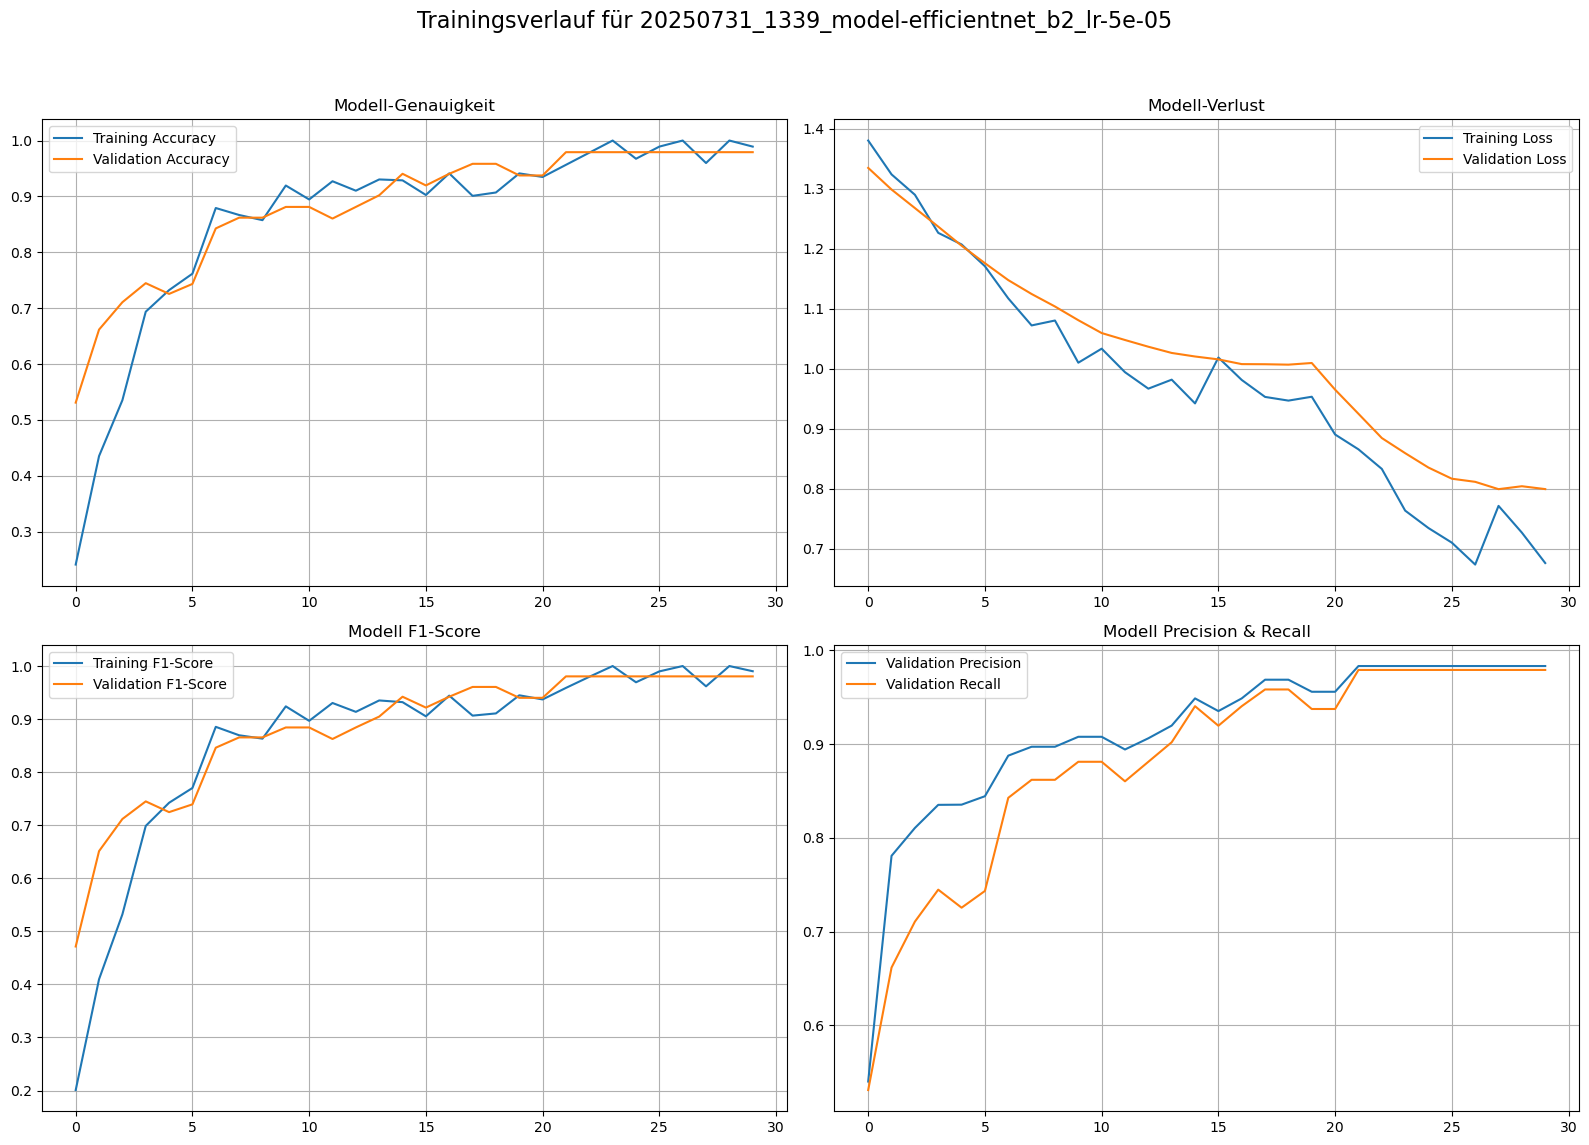


[INFO] Evaluiere bestes Modell auf dem unabhängigen Test-Set...
Finale Test-Genauigkeit: 0.9583
Finaler Test F1-Score: 0.9594


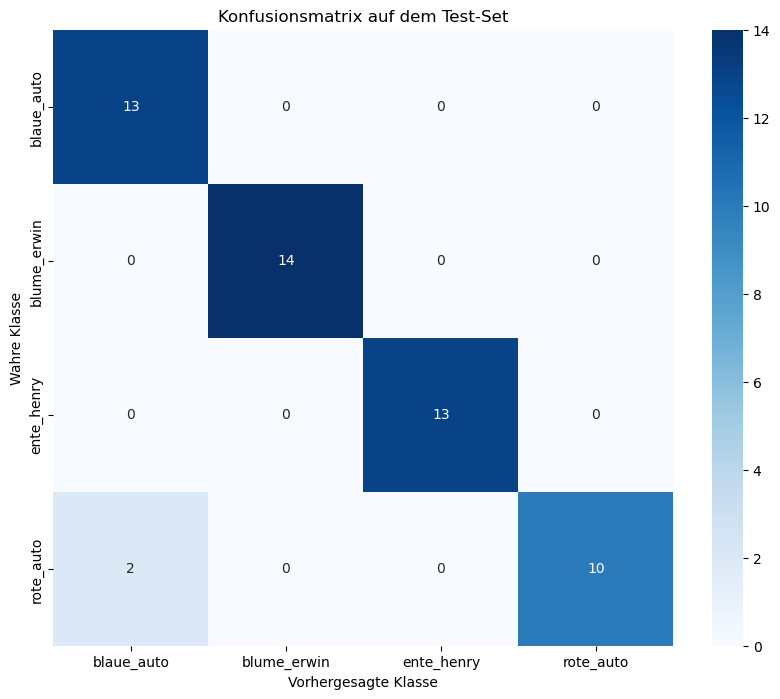


[INFO] Erstelle Visualisierung von Inferenz-Beispielen...


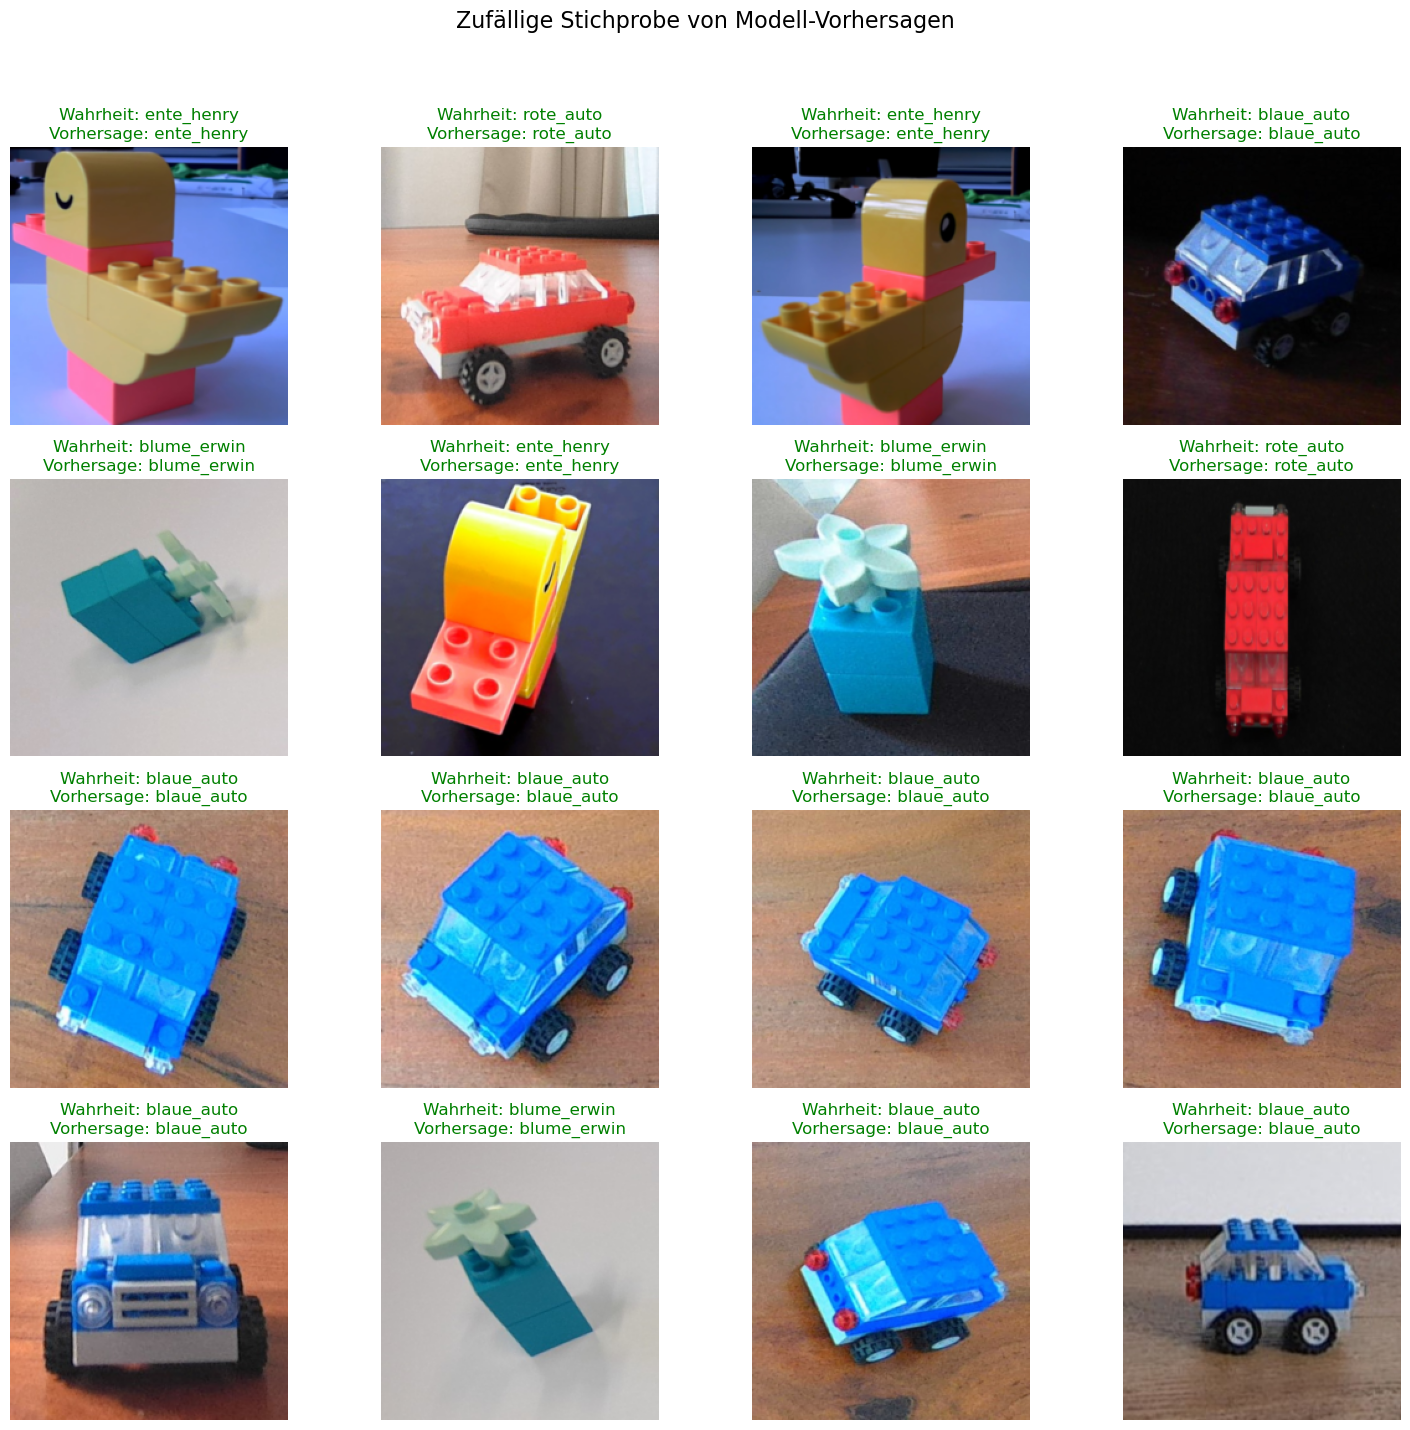


[INFO] Erstelle Grad-CAM Visualisierung...


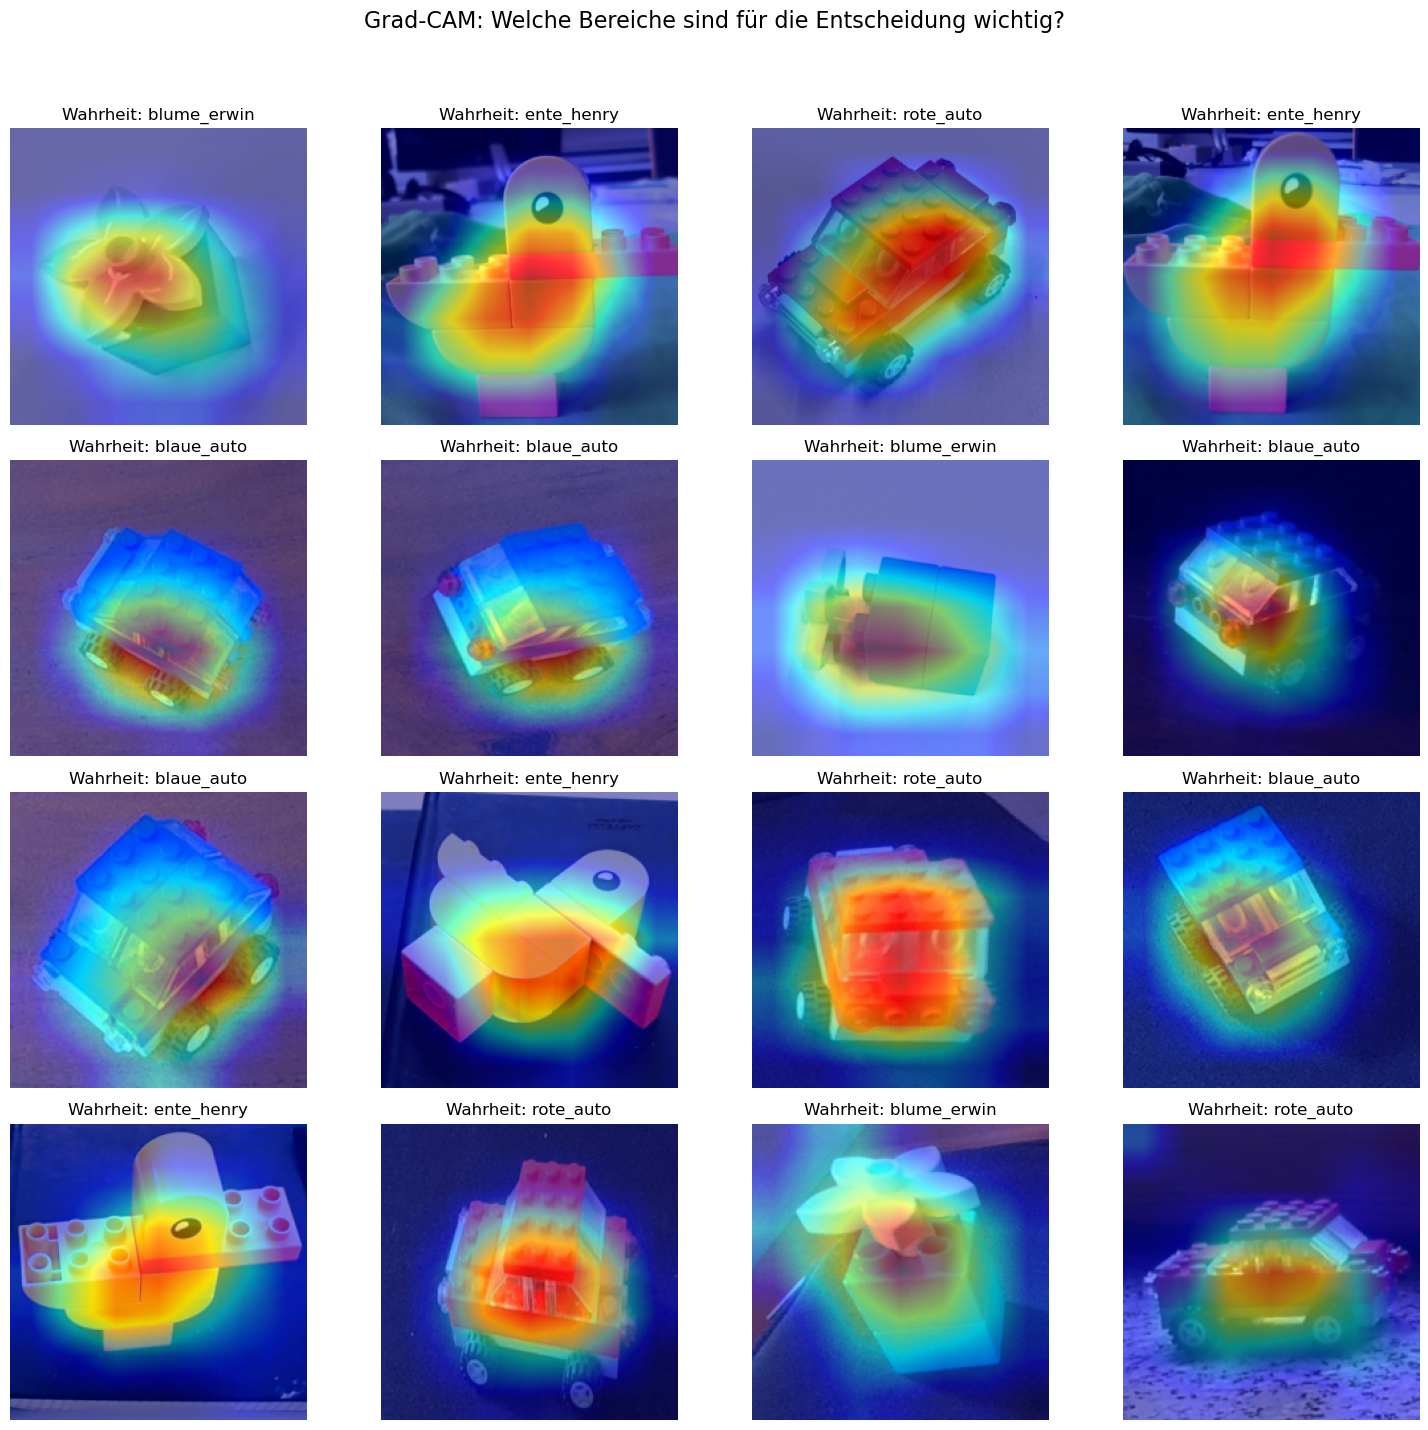

In [10]:
# ------------------------------------------------------------------------------
# 8. FINALE EVALUATION & VISUALISIERUNG
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle finale Auswertung und Visualisierungen...")
logs_df = pd.read_csv(os.path.join(run_dir, 'training_history.csv'))
fig, ax = plt.subplots(2, 2, figsize=(16, 12)); fig.suptitle(f'Trainingsverlauf für {run_name}', fontsize=16)
ax[0, 0].plot(logs_df['accuracy'], label='Training Accuracy'); ax[0, 0].plot(logs_df['val_accuracy'], label='Validation Accuracy'); ax[0, 0].set_title('Modell-Genauigkeit'); ax[0, 0].legend(); ax[0, 0].grid(True)
ax[0, 1].plot(logs_df['loss'], label='Training Loss'); ax[0, 1].plot(logs_df['val_loss'], label='Validation Loss'); ax[0, 1].set_title('Modell-Verlust'); ax[0, 1].legend(); ax[0, 1].grid(True)
ax[1, 0].plot(logs_df['f1_score'], label='Training F1-Score'); ax[1, 0].plot(logs_df['val_f1_score'], label='Validation F1-Score'); ax[1, 0].set_title('Modell F1-Score'); ax[1, 0].legend(); ax[1, 0].grid(True)
ax[1, 1].plot(logs_df['val_precision'], label='Validation Precision'); ax[1, 1].plot(logs_df['val_recall'], label='Validation Recall'); ax[1, 1].set_title('Modell Precision & Recall'); ax[1, 1].legend(); ax[1, 1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(os.path.join(run_dir, 'training_dashboard.png')); plt.show()

if test_dataset:
    print("\n[INFO] Evaluiere bestes Modell auf dem unabhängigen Test-Set...")
    model.load_state_dict(torch.load(os.path.join(run_dir, 'best_model.pth'))); model.eval()
    test_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    test_f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    conf_matrix = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(device)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_accuracy.update(outputs, labels); test_f1.update(outputs, labels); conf_matrix.update(outputs, labels)
    print(f"Finale Test-Genauigkeit: {test_accuracy.compute().item():.4f}"); print(f"Finaler Test F1-Score: {test_f1.compute().item():.4f}")
    cm = conf_matrix.compute().cpu().numpy()
    plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Vorhergesagte Klasse'); plt.ylabel('Wahre Klasse'); plt.title('Konfusionsmatrix auf dem Test-Set')
    plt.savefig(os.path.join(run_dir, 'confusion_matrix.png')); plt.show()

    # -- NEU: Visualisierung von Inferenz-Beispielen --
    print("\n[INFO] Erstelle Visualisierung von Inferenz-Beispielen...")
    vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(vis_loader)); images, labels = images.to(device), labels.to(device)
    with torch.no_grad(): outputs = model(images); predictions = torch.argmax(outputs, dim=-1)
    fig, axes = plt.subplots(4, 4, figsize=(15, 15)); fig.suptitle('Zufällige Stichprobe von Modell-Vorhersagen', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i >= len(images): ax.axis('off'); continue
        true_label = CLASSES[labels[i].item()]; pred_label = CLASSES[predictions[i].item()]
        ax.imshow(denormalization(images[i].cpu()))
        ax.set_title(f"Wahrheit: {true_label}\nVorhersage: {pred_label}", color="green" if true_label == pred_label else "red")
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(os.path.join(run_dir, 'prediction_examples.png')); plt.show()

    # -- Grad-CAM Visualisierung --
    print("\n[INFO] Erstelle Grad-CAM Visualisierung...")
    model.eval()
    for param in model.parameters(): param.requires_grad = True # Temporär für Grad-CAM auftauen
    target_layers = [model.conv_head]; cam = GradCAM(model=model, target_layers=target_layers)
    images, labels = next(iter(vis_loader)); images, labels = images.to(device), labels.to(device)
    grayscale_cam = cam(input_tensor=images, aug_smooth=True)
    fig, axes = plt.subplots(4, 4, figsize=(15, 15)); fig.suptitle('Grad-CAM: Welche Bereiche sind für die Entscheidung wichtig?', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i >= len(images): ax.axis('off'); continue
        cam_image = show_cam_on_image(denormalization(images[i].cpu()), grayscale_cam[i, :], use_rgb=True)
        ax.imshow(cam_image); ax.set_title(f"Wahrheit: {CLASSES[labels[i].item()]}"); ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(os.path.join(run_dir, 'grad_cam_examples.png')); plt.show()

In [8]:
# ==============================================================================
# 9. FINE-TUNING (OPTIONALER SCHRITT ZUR VERBESSERUNG)
# ==============================================================================
# Dieser Block kann in einer NEUEN ZELLE nach dem ersten Training ausgeführt werden,
# um das Modell weiter zu verbessern.

print("\n[INFO] Bereite das Modell für das Fine-Tuning vor...")
best_model_path = os.path.join(run_dir, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Bestes Modell aus '{run_dir}' erfolgreich geladen.")
else:
    print(f"[WARNUNG] Konnte kein vortrainiertes Modell finden.")

print("Taue die letzte Schichtengruppe für das Fine-Tuning auf...")
for param in model.blocks[-1].parameters():
    param.requires_grad = True

FINE_TUNE_LEARN_RATE = 1e-6
LEARN_RATE_HEAD = 5e-5
optimizer = optim.Adam([
    {'params': model.classifier.parameters(), 'lr': LEARN_RATE_HEAD},
    {'params': model.blocks[-1].parameters(), 'lr': FINE_TUNE_LEARN_RATE}
])

NUM_EPOCHS = 10
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-7)
summary_info = summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), verbose=0)
print(f"Neue Anzahl trainierbarer Parameter: {summary_info.trainable_params:,}")
print("\n[INFO] Setup für Fine-Tuning abgeschlossen. Führe jetzt die Zelle mit der Trainings-Schleife erneut aus.")


[INFO] Bereite das Modell für das Fine-Tuning vor...
Bestes Modell aus '/myraid/LEGO_Project/models/20250731_1339_model-efficientnet_b2_lr-5e-05' erfolgreich geladen.
Taue die letzte Schichtengruppe für das Fine-Tuning auf...
Neue Anzahl trainierbarer Parameter: 8,424,454

[INFO] Setup für Fine-Tuning abgeschlossen. Führe jetzt die Zelle mit der Trainings-Schleife erneut aus.
